# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

### Задание 1 (1 балл)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def gini(x):
    vc = x.value_counts(normalize=True, sort=False)
    return (vc * (1-vc)).sum()
    
def entropy(x):
    vc = x.value_counts(normalize=True, sort=False)
    return -(vc * np.log2(vc)).sum()

def gain(left_y, right_y, criterion):
    n = left_y.size + right_y.size
    return criterion(left_y.append(right_y)) - criterion(left_y)*(left_y.size / n) - criterion(right_y)*(right_y.size / n)

In [12]:
entropy(pandas.Series([1, 2, 3, 4]))

2.0

In [20]:
gini(pandas.Series([1, 1, 2, 3]))

0.625

In [31]:
gain(pandas.Series([0, 0, 1, 1, 1, 1]), pandas.Series([0, 0]), entropy)

0.31127812445913283

In [32]:
gain(pandas.Series([0, 0, 1, 1, 1, 1]), pandas.Series([0, 0]), gini)

0.16666666666666663

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [78]:
class DecisionTreeLeaf:
    def __init__(self, y, ps):
        self.y = y
        self.ps = ps

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [89]:
class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.criterion = entropy if criterion == "entropy" else gini
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.probs = {}
    
    def fit(self, X, y):
        self.root = self.do_fit(X, y, 0)
    
    def do_fit(self, X, y, depth):
        if y.size <= self.min_samples_leaf or depth == self.max_depth or y.unique().size == 1:
            ps = y.value_counts(normalize=True, sort=False)
            return DecisionTreeLeaf(ps.idxmax(), ps.to_dict())
        node_info = self.split(X, y)
        left = self.do_fit(node_info['xl'], node_info['yl'], depth+1)
        right = self.do_fit(node_info['xr'], node_info['yr'], depth+1)
        return DecisionTreeNode(node_info['split_dim'], node_info['split_value'], left, right)
        
    def split(self, X, y):
        node_info = {'g': None}
        for col in X.columns:
            for v in X[col].sort_values().unique()[1:]:
                xl = X[X[col] < v]
                xr = X[X[col] >= v]
                yl = y.loc[xl.index]
                yr = y.loc[xr.index]
                g = gain(yl, yr, self.criterion)
                if node_info['g'] is None or g > node_info['g']:
                    node_info = {
                        'g': g,
                        'split_dim': col,
                        'split_value': v,
                        'xl': xl,
                        'xr': xr,
                        'yl': yl,
                        'yr': yr
                    }
        return node_info
    
    def predict_proba(self, X):
        self.probs = {}
        self.do_predict_proba(X, self.root)
        return list(map(lambda i: self.probs[i], X.index.to_list()))
    
    def do_predict_proba(self, X, node):
        if isinstance(node, DecisionTreeLeaf):
            for i in X.index:
                self.probs[i] = node.ps
        else:
            self.do_predict_proba(X[X[node.split_dim] < node.split_value], node.left)
            self.do_predict_proba(X[X[node.split_dim] >= node.split_value], node.right)
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [68]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%s] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [52]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Задание 4 (2 балла)

Протестируйте решение на данных cancer и spam (датасеты из директории `hw2_data`).
Выполните загрузку и предобработку данных.


Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.

Посчитайте метрики `precision`, `recall`, `accuracy` для модели дерева.
Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`). 

Какой нужен препроцессинг данных для моделей?
Какая модель делает предсказания лучше?  Предположите, почему.

### ответ:

нужна балансировка тренировочных данных, выбрал oversampling, чтобы не терять информацию

кодировать категориальные признаки не требуется, так как в датасетах cancer и spam все признаки числовые

обрабатывать пропущенные значения не надо, так как в датасетах cancer и spam нет значений None или странных выбросов



In [93]:
from sklearn.metrics import accuracy_score, \
                            recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

In [92]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pandas.read_csv(path_to_csv)
    return df.drop(['label'], axis=1), df['label'].apply(lambda t: 1 if t == 'M' else 0)

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pandas.read_csv(path_to_csv)
    return df.drop(['label'], axis=1), df['label']

def train_test_split(X, y, ratio):
    rows = random.sample(X.index.to_list(), round(ratio*len(X.index)))
    X_test = X.loc[rows]
    y_test = y.loc[rows]
    X_train = X.loc[~X.index.isin(rows)]
    y_train = y.loc[~y.index.isin(rows)]
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    return X_train, y_train, X_test, y_test

def oversampling(X, y):
    over = y.value_counts().idxmax()
    
    y_min = y[y != over]
    y_max = y[y == over]
    X_min = X.filter(y_min.index,axis = 0)
    X_max = X.filter(y_max.index,axis = 0)
    
    rows = random.choices(X_min.index.to_list(),k=len(y_max.index))
    X_over = X_min.loc[rows]
    y_over = y_min.loc[rows]
    
    X_over = pandas.concat([X_over, X_max])
    y_over = pandas.concat([y_over, y_max])
    
    # Возвращает данные, сбалансированные методом oversampling
    return X_over, y_over

CANCER_DATA_PATH = 'hw2_data/cancer.csv'
SPAM_DATA_PATH = 'hw2_data/spam.csv'

X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)

In [91]:
X_train_imb, y_train_imb, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
X_train, y_train = oversampling(X_train_imb, y_train_imb)

### cancer, decision tree

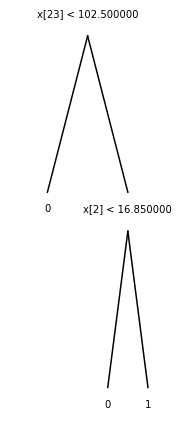

In [104]:
tree.fit(X_train, y_train)
draw_tree(tree)

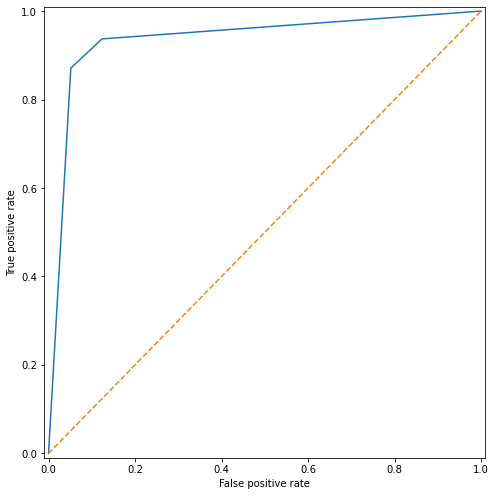

In [105]:
plot_roc_curve(y_test, tree.predict_proba(X_test))

### cancer, kNN

### spam, decision tree

In [106]:
X_train_imb, y_train_imb, X_test, y_test = train_test_split(X_spam, y_spam, 0.9)
X_train, y_train = oversampling(X_train_imb, y_train_imb)

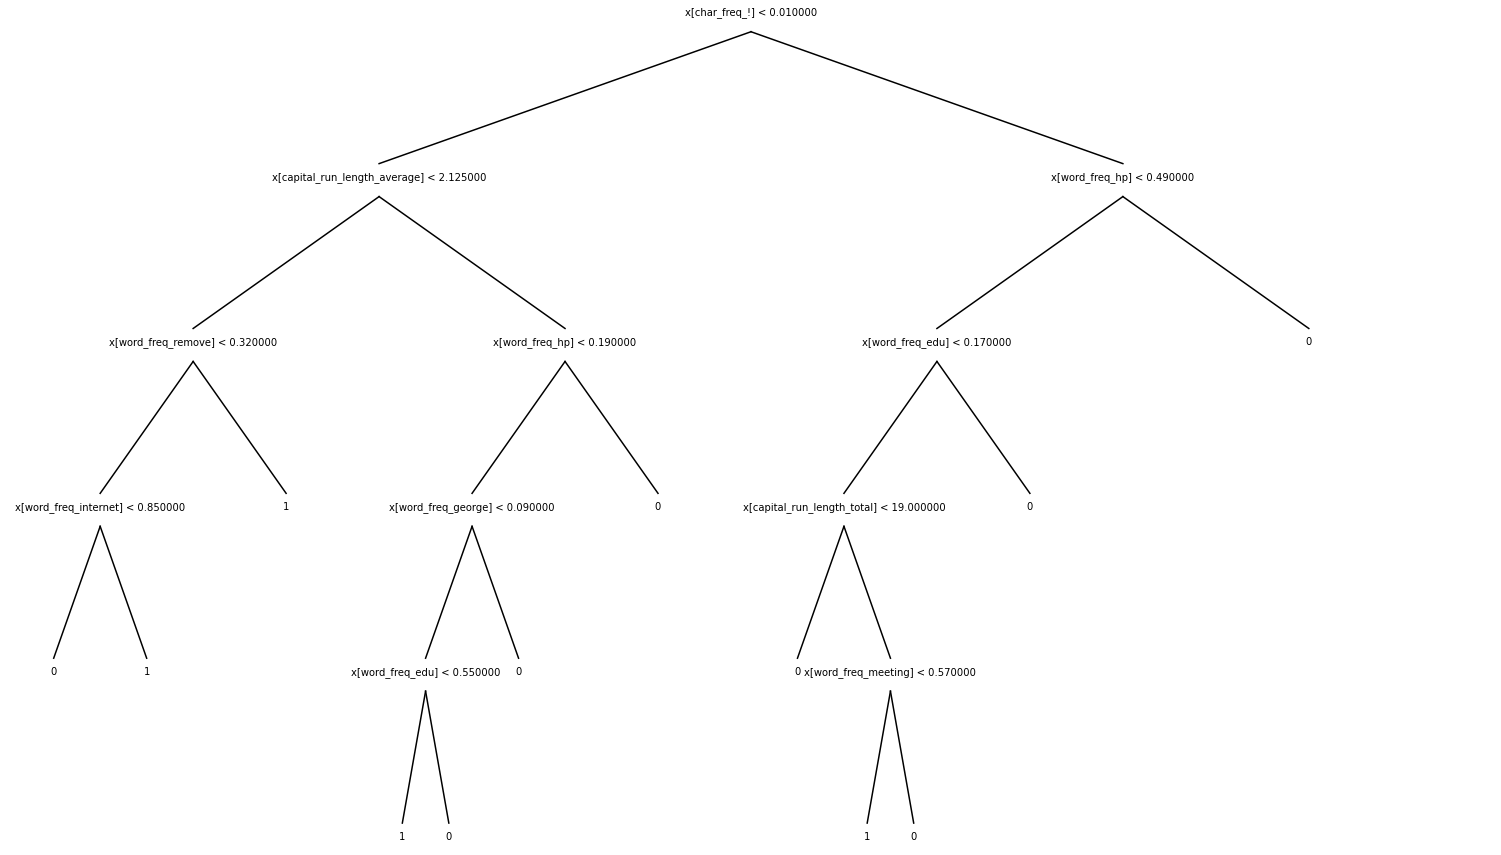

In [107]:
tree.fit(X_train, y_train)
draw_tree(tree)

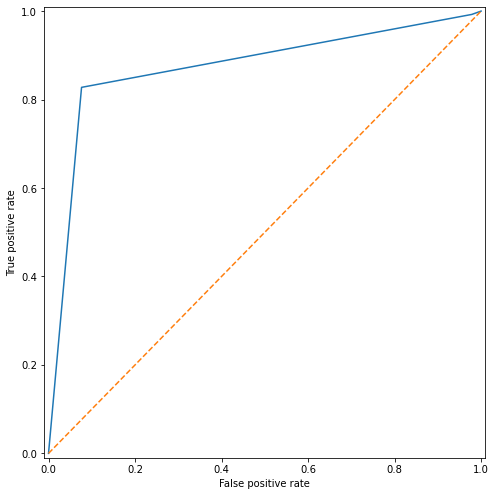

In [108]:
plot_roc_curve(y_test, tree.predict_proba(X_test))

### spam, kNN